In [1]:
from sympy import *
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import os
import pandas as pd
import fenics as fe

In [28]:
# Test Parameter
ConstitutiveModels = ['NeoHookean', 'MooneyRivlin', 'Gent', 'Demiray', 'Ogden']
ConstitutiveModel  = ConstitutiveModels[0]   # Constitutive model used for comparison

BoundaryConditionsTypes = ['Ideal','Real']
BoundaryConditionsType = BoundaryConditionsTypes[0]

LoadCases = ['TensionCompression','SimpleShear']
LoadCase = LoadCases[0]

URange = [0.1, 5]                          # Stretch ratio interval
Delta  =  0.01                               # Step size

# Discretization (number of elements by sides)
Nelements = 2

# Material Parameters
LambdaV =  1E6   # 1st Lamé parameter
MuV     =  660   # 2nd Lamé parameter (Shear modulus) (Pa)

C01V   =  0.00   # Mooney-Rivlin 3rd material constant (kPa) if == 0 => Neo-Hookean
JmV    =  0.08   # Gent 3rd material constant (-) if == 1 => ~Neo-Hookean with ln
BetaV  =  20.3   # Demiray 3rd material constant (-) if == 1 => ~Neo-Hookean with exp
AlphaV = -24.3   # Ogden 3rd material constant (-) if == 2 => Neo-Hookean

# Folder for the results
Output_Path = os.path.join('Results', 'Compressible', str(BoundaryConditionsType) + ' Boundary Conditions', ConstitutiveModel, str(Nelements) + ' Elements')
os.makedirs(Output_Path, exist_ok=True)

In [29]:
# Finite Element Solution

# Geometry (mm)
Length, Thickness, Height = [5, 5, 5]

# Mesh
Mesh = fe.BoxMesh(fe.Point(-Length/2, -Thickness/2, -Height/2), fe.Point( Length/2, Thickness/2, Height/2), Nelements, Nelements, Nelements)

# Discretization type
Type = 'Lagrange'
PolDegree = 1

# Functions spaces
V_ele = fe.VectorElement(Type, Mesh.ufl_cell(), PolDegree)
V     = fe.VectorFunctionSpace(Mesh, Type, PolDegree)

# Finite element functions
du    = fe.TrialFunction(V)
v     = fe.TestFunction(V)
u     = fe.Function(V)

# Kinematics
d = u.geometric_dimension()
I = fe.Identity(d)                    # Identity tensor
F = I + fe.grad(u)                    # Deformation gradient
F = fe.variable(F)                    # To differentiate Psi(F)
C = F.T*F                             # Right Cauchy-Green deformation tensor

# Invariants
J = fe.det(F)                         # Jacobian of F
Ic = fe.tr(C)                         # Trace of C

def I1(C):
    return fe.tr(C)

def I1b(C):
    return J**(-2/3)*I1(C)

def I2(C):
    c1 = C[0,0]*C[1,1] + C[0,0]*C[2,2] + C[1,1]*C[2,2]
    c2 = C[0,1]*C[0,1] + C[0,2]*C[0,2] + C[1,2]*C[1,2]
    return c1 - c2

def I3(C):
    return fe.det(C)

# Define function necessary for eigenvalues computation
def v_inv(C):
    return (I1(C)/3.)**2 - I2(C)/3.

def s_inv(C):
    return (I1(C)/3.)**3 - I1(C)*I2(C)/6. + I3(C)/2.

def phi_inv(C):
    arg = s_inv(C)/v_inv(C)*fe.sqrt(1./v_inv(C))
    # numerical issues if arg~0
    # https://fenicsproject.org/qa/12299
    # /nan-values-when-computing-arccos-1-0-bug/
    arg_cond = fe.conditional( fe.ge(arg, 1-fe.DOLFIN_EPS),
    1-fe.DOLFIN_EPS,fe.conditional( fe.le(arg, -1+fe.DOLFIN_EPS),
    -1+fe.DOLFIN_EPS, arg ))
    return fe.acos(arg_cond)/3.

# Eigenvalues of the strech tensor C
lambda_1 = Ic/3. + 2*fe.sqrt(v_inv(C))*fe.cos(phi_inv(C))
lambda_2 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. + phi_inv(C))
lambda_3 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. - phi_inv(C))

# Hyperelastic models (compressibles)
if ConstitutiveModel == ConstitutiveModels[0]:     # Neo-Hookean
    FileName = LoadCase + '_Lambda' + str(LambdaV/1E6) + 'E6_Mu' + str(MuV)
    C1 = MuV/2
    D1 = LambdaV/2
    Psi = C1 * (I1b(C) - 3) + D1 * (J-1)**2
    
# elif ConstitutiveModel == ConstitutiveModels[1]:   # Mooney-Rivlin
#     FileName = LoadCase + '_Lambda' + str(LambdaV/1E6) + 'E6_Mu' + str(MuV) + '_C01' + str(C01V)
#     Psi = C01V * (J**(-4/3)*I2(C) - 3) + (MuV / 2 - C01V) * (J**(-2/3)*I1(C) - 3) - p*fe.ln(J)

# elif ConstitutiveModel == ConstitutiveModels[2]:   # Gent
#     FileName = LoadCase + '_Lambda' + str(LambdaV/1E6) + 'E6_Mu' + str(MuV) + '_Jm' + str(JmV)
#     Psi = - MuV*JmV/2 * fe.ln(1 - (I1(C) - 3) / JmV) - p*fe.ln(J)

# elif ConstitutiveModel == ConstitutiveModels[3]:   # Demiray
#     FileName = LoadCase + '_Lambda' + str(LambdaV/1E6) + 'E6_Mu' + str(MuV) + '_Beta' + str(BetaV)
#     Psi = MuV/2 * (fe.exp(BetaV*(I1(C) - 3)) - 1) / BetaV - p*fe.ln(J)

# elif ConstitutiveModel == ConstitutiveModels[4]:   # Ogden
#     FileName = LoadCase + '_Lambda' + str(LambdaV/1E6) + 'E6_Mu' + str(MuV) + '_Alpha' + str(AlphaV)
#     PSiEstimate = Psi = (MuV/2)*(I1(C) - 3) - p*fe.ln(J)
#     Psi = 2 * MuV * (lambda_1**(AlphaV/2.) + lambda_2**(AlphaV/2.) + lambda_3**(AlphaV/2.) - 3) / AlphaV**2 - p*fe.ln(J)

# Subdomains definition
class LowerSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], -Height/2, tol)
    
class UpperSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], Height/2, tol)
    
# Define integration over subdomains
Domains_Facets = fe.MeshFunction('size_t', Mesh, Mesh.geometric_dimension()-1)
ds = fe.Measure('ds', domain=Mesh, subdomain_data=Domains_Facets)

# Mark all domain facets with 0
Domains_Facets.set_all(0)

# Mark bottom facets with 1
bottom = LowerSide()
bottom.mark(Domains_Facets, 1)

# Mark upper facets with 2
upper = UpperSide()
upper.mark(Domains_Facets, 2)

# Boundary conditions
if BoundaryConditionsType == BoundaryConditionsTypes[0]:

    u_0 = fe.Constant((0))                # No displacement
    
    if LoadCase == LoadCases[0]:
        u_1 = fe.Expression(('(s-1)*h'), degree=1, s = URange[0], h = Height )
        Dir = fe.Constant((0,0,1))            # Deformation direction
    elif LoadCase == LoadCases[1]:
        print('Invalid combination of load case and boundary conditions')

    # Apply boundary conditions
    bcl = fe.DirichletBC(V.sub(2), u_0, Domains_Facets, 1)
    bcu = fe.DirichletBC(V.sub(2), u_1, Domains_Facets, 2)
    
elif BoundaryConditionsType == BoundaryConditionsTypes[1]:

    u_0 = fe.Constant((0,0,0))            # No displacement
    
    if LoadCase == LoadCases[0]:
        u_1 = fe.Expression(('0','0','(s-1)*h'), degree=1, s = URange[0], h = Height )
        Dir = fe.Constant((0,0,1))            # Deformation direction
    elif LoadCase == LoadCases[1]:
        u_1 = fe.Expression(('s*h','0','0'), degree=1, s = URange[0], h = Height )
        Dir = fe.Constant((1,0,0))            # Deformation direction

    # Apply boundary conditions
    bcl = fe.DirichletBC(V, u_0, Domains_Facets, 1)
    bcu = fe.DirichletBC(V, u_1, Domains_Facets, 2)

# Normal to moving side
n = fe.Constant((0, 0, 1))

# Set of boundary conditions
bcs = [bcl, bcu]

if ConstitutiveModel == ConstitutiveModels[4]:   # Ogden need estimation

    # Total potential energy
    Pi = PSiEstimate * fe.dx
    
    # First directional derivative of the potential energy
    Fpi = fe.derivative(Pi,u,v)

    # Jacobian of Fpi
    Jac = fe.derivative(Fpi,u,du)

    # Define option for the compiler (optional)
    ffc_options = {"optimize": True, \
                   "eliminate_zeros": True, \
                   "precompute_basis_const": True, \
                   "precompute_ip_const": True, \
                   "quadrature_degree": 2, \
                   "representation" : "uflacs" }

    # Define the problem
    problem = fe.NonlinearVariationalProblem(Fpi, u, bcs, Jac, form_compiler_parameters=ffc_options)

    # Define the solver
    solver = fe.NonlinearVariationalSolver(problem)

    # Set solver parameters (optional)
    prm = solver.parameters
    prm['newton_solver']['linear_solver'] = 'mumps'
    fe.parameters["form_compiler"]["representation"] = "uflacs"
    fe.parameters["form_compiler"]["quadrature_degree"] = 2
    
    # Set initial displacement
    if LoadCase == LoadCases[0]:
        u_1.s = URange[0]
    elif LoadCase == LoadCases[1]:
        u_1.s = URange[0]+Delta
    
    # Compute solution and save displacement
    solver.solve()

# Total potential energy
Pi = Psi * fe.dx

# First directional derivative of the potential energy
Fpi = fe.derivative(Pi,u,v)

# Jacobian of Fpi
Jac = fe.derivative(Fpi,u,du)

# Define option for the compiler (optional)
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True, \
               "quadrature_degree": 2, \
               "representation" : "uflacs" }

# Define the problem
problem = fe.NonlinearVariationalProblem(Fpi, u, bcs, Jac, form_compiler_parameters=ffc_options)

# Define the solver
solver = fe.NonlinearVariationalSolver(problem)

# Set solver parameters (optional)
prm = solver.parameters
prm['newton_solver']['linear_solver'] = 'mumps'
fe.parameters["form_compiler"]["representation"] = "uflacs"
fe.parameters["form_compiler"]["quadrature_degree"] = 2

# Results File
# results = xdmffile = fe.XDMFFile(os.path.join(Output_Path, FileName + '.xdmf'))
# results.parameters['flush_output'] = True
# results.parameters['functions_share_mesh'] = True

# Data frame to store values
DataFrame = pd.DataFrame({'Stretch Ratio (-)':URange})

# Set the stretch state to initial state
StretchState = URange[0]

for Step in range(int((URange[1]-URange[0])/Delta+1)):
    
#     print('Stretch state: %.2f'%(StretchState))
    
    if ConstitutiveModel == ConstitutiveModels[4] and LoadCase == LoadCases[0] and round(StretchState,3) == 1.000:   # Ogden
        print('Artificial stress added in dataframe at stretch state of 1.0')
        DataFrame = DataFrame.append({'Stretch Ratio (-)':round(StretchState,3),'Stress (Pa)':0}, ignore_index=True)
        StretchState += Delta
#         print('Stretch state: %.2f'%(StretchState))

    elif ConstitutiveModel == ConstitutiveModels[4] and LoadCase == LoadCases[1] and round(StretchState,3) == 0.000:   # Ogden
        print('Artificial stress added in dataframe at stretch state of 1.0')
        DataFrame = DataFrame.append({'Stretch Ratio (-)':round(StretchState,3),'Stress (Pa)':0}, ignore_index=True)
        StretchState += Delta
#         print('Stretch state: %.2f'%(StretchState))
    
    # Update current state
    u_1.s = StretchState
    
    # Compute solution and save displacement
    solver.solve()
    
    # First Piola Kirchoff (nominal) stress
    P = fe.diff(Psi, F)
    
    # Nominal stress vectors normal to upper surface
    p = fe.dot(P,n)
    
    # Reaction force on the upper surface
    f = fe.assemble(fe.inner(p,Dir)*ds(2))
    
    # Mean nominal stress on the upper surface
    Pm = f/fe.assemble(1*ds(2))
    
    # Project the displacement onto the vector function space
    u_project = fe.project(u, V, solver_type='cg')
    u_project.rename('displacement (mm)', '')
#     results.write(u_project,Step)
    
    # Save values to table
    DataFrame = DataFrame.append({'Stretch Ratio (-)':round(StretchState,3),'Stress (Pa)':Pm}, ignore_index=True)

    # Update the stretch state
    StretchState += Delta
    
    # Save dataframe
    DataFrame.to_csv(os.path.join(Output_Path, FileName + '.csv'), index=False)

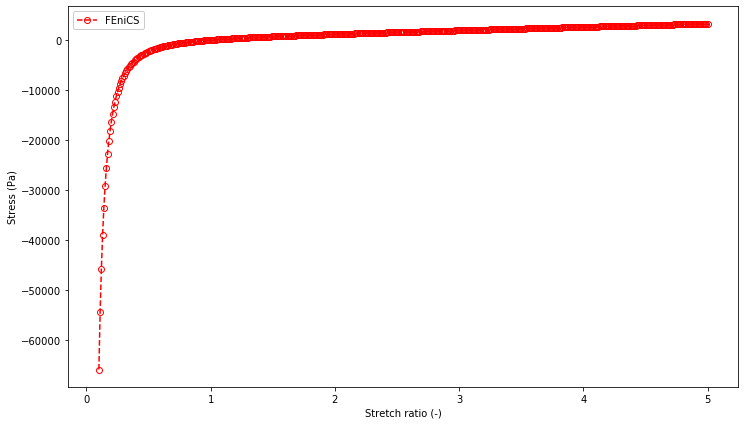

In [30]:
## Plot Results
plt.figure(figsize=(12,7))
ax = plt.subplot(1, 1, 1)
DataFrame.plot(x='Stretch Ratio (-)', y='Stress (Pa)', ax=ax, color = 'red', linestyle = '--', marker='o', fillstyle='none', label='FEniCS')
ax.set_xlabel('Stretch ratio (-)')
ax.set_ylabel('Stress (Pa)')
plt.legend(loc='upper left', frameon=True, framealpha=1)
plt.savefig(os.path.join(Output_Path, FileName + '_Plot.pdf'))
plt.show()